In [1]:
import torch
from torchvision import datasets, transforms


In [2]:
get_smile = lambda attr:attr[31]

# tranform the imagees randomly in the training set
train_transforms = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
   
])

# transform the images in the validation set
tranform = transforms.Compose([ 
    transforms.CenterCrop([178, 178]), 
    transforms.Resize([64, 64]),
    transforms.ToTensor(),
])

In [3]:
# # Load the CelebA dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

celeba_train_dataset = datasets.CelebA(root='../', split='train', target_type="attr", transform=train_transforms, target_transform=get_smile, download=False)
celeba_test_dataset = datasets.CelebA(root='../', split='test', target_type="attr",  transform=tranform,target_transform=get_smile, download=False)
celeba_valid_dataset = datasets.CelebA(root='../', split='valid', target_type="attr", transform=tranform,target_transform=get_smile, download=False) 


print(len(celeba_train_dataset))
print(len(celeba_test_dataset))
print(len(celeba_valid_dataset))



# # Create the dataloaders

torch.manual_seed(1)
data_loader= DataLoader(celeba_train_dataset, batch_size=2)



162770
19962
19867


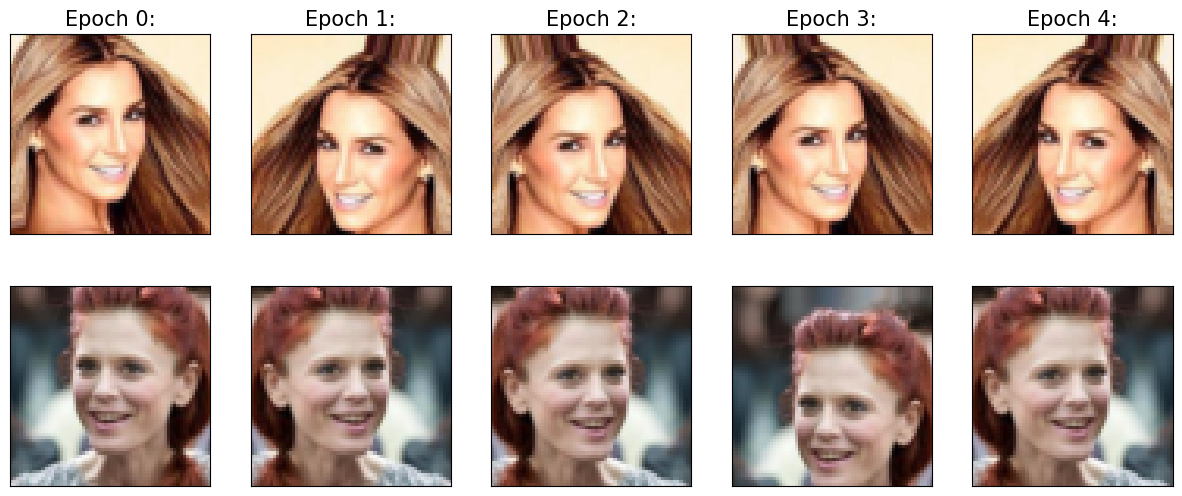

In [4]:
fig= plt.figure(figsize=(15, 6))
num_epochs= 5
for j in range(num_epochs):
    img_batch,label= next(iter(data_loader))
    img = img_batch[0]
    ax = fig.add_subplot(2, 5, j + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Epoch {j}:', size=15)
    ax.imshow(img.permute(1, 2, 0))
    img = img_batch[1]
    ax = fig.add_subplot(2, 5, j + 6)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))
plt.show()
      

In [5]:
from torch.utils.data import Subset
caleba_train_dataset = Subset(celeba_train_dataset, range(16000))
celeba_test_dataset = Subset(celeba_valid_dataset, range(1000))
# dataloaders
train_dl = DataLoader(celeba_train_dataset, batch_size=32, shuffle=True)
test_dl = DataLoader(celeba_test_dataset, batch_size=32, shuffle=False)
valid_dl = DataLoader(celeba_valid_dataset, batch_size=32, shuffle=False)


In [6]:
import torch.nn as nn
import torch.optim as optim


model= nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=32,kernel_size=3, padding=1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('dropout1', nn.Dropout(p=0.5))

model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('dropout2', nn.Dropout(p=0.5))


model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2, stride=2))
model.add_module('dropout3', nn.Dropout(p=0.5))

model.add_module("conv4", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))

# average pooling layer 
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten', nn.Flatten())

model.add_module('fc1', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())


model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout3): Dropout(p=0.5, inplace=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [7]:
loss_fn = nn.BCELoss()  # binary cross entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer: adaptive moment estimation 

In [8]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        model.train()   
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch.float())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = ((pred >= 0.5).float() == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        # Validation loop
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                y_pred = model(x_batch)[:, 0]
                loss = loss_fn(y_pred, y_batch.float())
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)

                # Use y_pred in validation, not pred
                is_correct = ((y_pred >= 0.5).float() == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()

            loss_hist_valid[epoch] /= len(valid_dl.dataset)
            accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, train_loss: {loss_hist_train[epoch]:.4f}, train_accuracy: {accuracy_hist_train[epoch]:.4f}, valid_loss: {loss_hist_valid[epoch]:.4f}, valid_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    
    return loss_hist_train, accuracy_hist_train, loss_hist_valid, accuracy_hist_valid


In [9]:
torch.manual_seed(1)
num_epochs=5
hist=train(model,num_epochs,train_dl,valid_dl)


Epoch 1/5, train_loss: 0.6712, train_accuracy: 0.5748, valid_loss: 0.6482, valid_accuracy: 0.6189
Epoch 2/5, train_loss: 0.6130, train_accuracy: 0.6655, valid_loss: 0.5126, valid_accuracy: 0.7756
Epoch 3/5, train_loss: 0.5005, train_accuracy: 0.7580, valid_loss: 0.4095, valid_accuracy: 0.8228
Epoch 4/5, train_loss: 0.4248, train_accuracy: 0.8091, valid_loss: 0.3131, valid_accuracy: 0.8748
Epoch 5/5, train_loss: 0.3822, train_accuracy: 0.8324, valid_loss: 0.3148, valid_accuracy: 0.8702


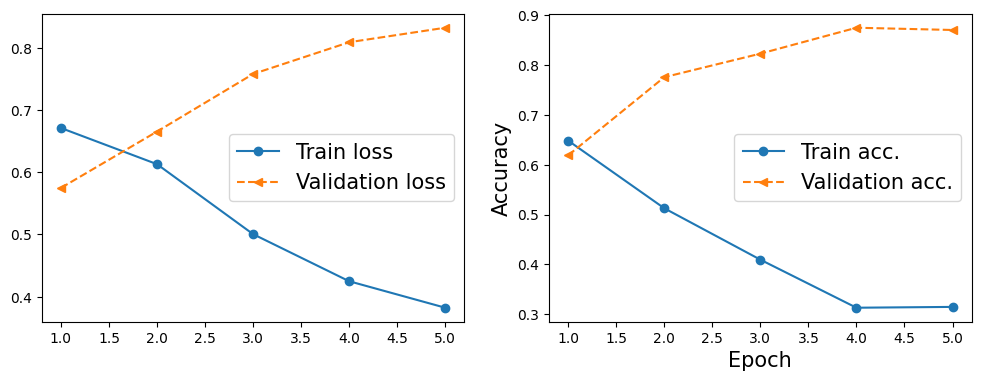

In [11]:
import numpy as np 
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<',
label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [10]:
torch.save(model.state_dict(), 'model-smile.pth')

In [12]:
accuracy_test = 0
model.eval()

with torch.no_grad():
    for x_batch, y_batch in test_dl:
        pred = model(x_batch)[:, 0]
        is_correct = ((pred>=0.5).float() == y_batch).float()
        accuracy_test += is_correct.sum()
        accuracy_test /= len(test_dl.dataset)

print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.0060


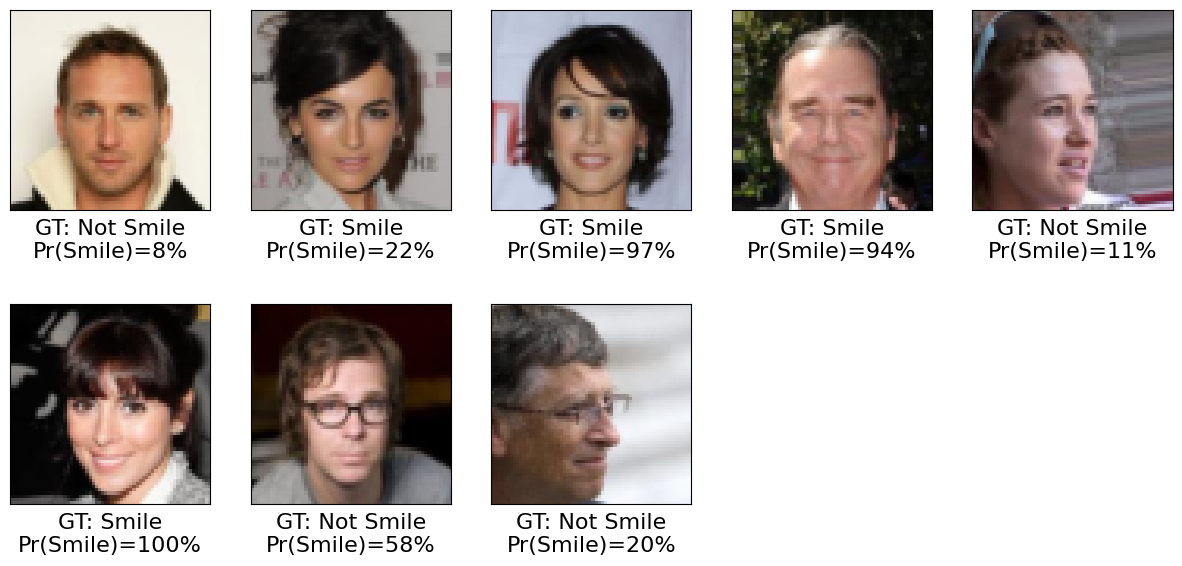

In [15]:
batch_size = x_batch.size(0)  # Get the actual batch size (8 in this case)
pred = model(x_batch)[:, 0] * 100

fig = plt.figure(figsize=(15, 7))
for j in range(min(10, batch_size)):  # Loop only up to the available batch size
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))  # Display the image

    # Define the label
    label = 'Smile' if y_batch[j] == 1 else 'Not Smile'
    
    # Add text annotation
    ax.text(
        0.5, -0.15,
        f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%',
        size=16,
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes
    )
    
plt.show()


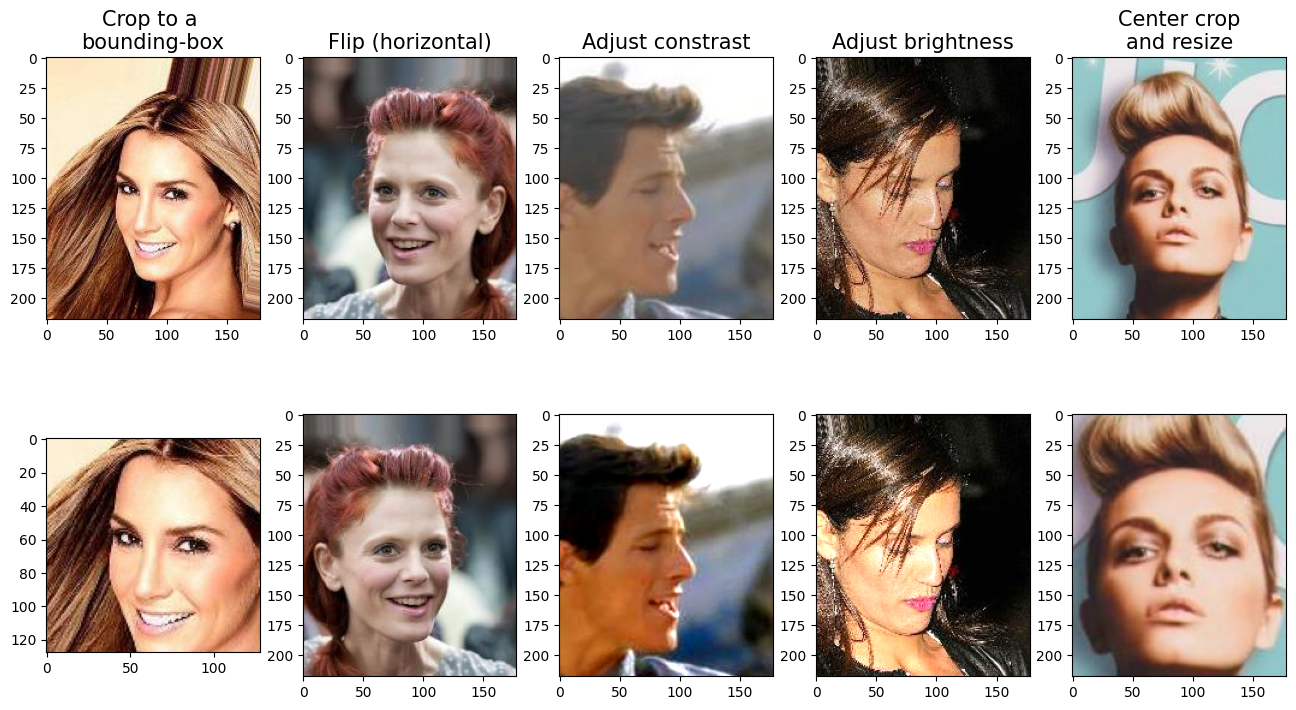

In [3]:
# _______________________________________________________TRANSFORMER, DATA AUGMENTATION_______________________________________________________
fig = plt.figure(figsize=(16, 8.5))
## Column 1: cropping to a bounding-box
ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train_dataset[0]
ax.set_title('Crop to a \nbounding-box', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 6)
img_cropped = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(img_cropped)

## Column 2: flipping (horizontally)
ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train_dataset[1]
ax.set_title('Flip (horizontal)', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 7)
img_flipped = transforms.functional.hflip(img)
ax.imshow(img_flipped)

## Column 3: adjust contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train_dataset[2]
ax.set_title('Adjust constrast', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 8)
img_adj_contrast = transforms.functional.adjust_contrast(
img, contrast_factor=2
)
ax.imshow(img_adj_contrast)

## Column 4: adjust brightness
ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train_dataset[3]
ax.set_title('Adjust brightness', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 9)
img_adj_brightness = transforms.functional.adjust_brightness(
img, brightness_factor=1.3
)
ax.imshow(img_adj_brightness)

## Column 5: cropping from image center
ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train_dataset[4]
ax.set_title('Center crop\nand resize', size=15)
ax.imshow(img)
ax = fig.add_subplot(2, 5, 10)
img_center_crop = transforms.functional.center_crop(
img, [0.7*218, 0.7*178]
)
img_resized = transforms.functional.resize(
img_center_crop, size=(218, 178)
)
ax.imshow(img_resized)
plt.show()